In [1]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import yfinance as yf
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [5]:
def get_historical_data(symbol, start_date , end_date):
    df=yf.download(symbol, start=start_date, end=end_date)
    return df

In [88]:
start = pd.to_datetime('2020-01-01')
end = pd.to_datetime('2022-01-01')
symbol = 'BTC-USD'

aapl = get_historical_data(symbol, start , end)
aapl

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299


In [89]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

In [90]:
aapl_macd = get_macd(aapl['Close'], 26, 12, 9)
aapl_macd

,macd,signal,hist
Date,,,
2020-01-01,0.000000,0.000000,0.000000
2020-01-02,-17.127393,-3.425479,-13.701914
2020-01-03,-1.679899,-3.076363,1.396464
2020-01-04,15.688789,0.676668,15.012121
2020-01-05,29.170646,6.375463,22.795183
...,...,...,...
2021-12-27,-864.435586,-1635.771146,771.335561
2021-12-28,-963.158844,-1501.248686,538.089842
2021-12-29,-1120.800746,-1425.159098,304.358352


In [91]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

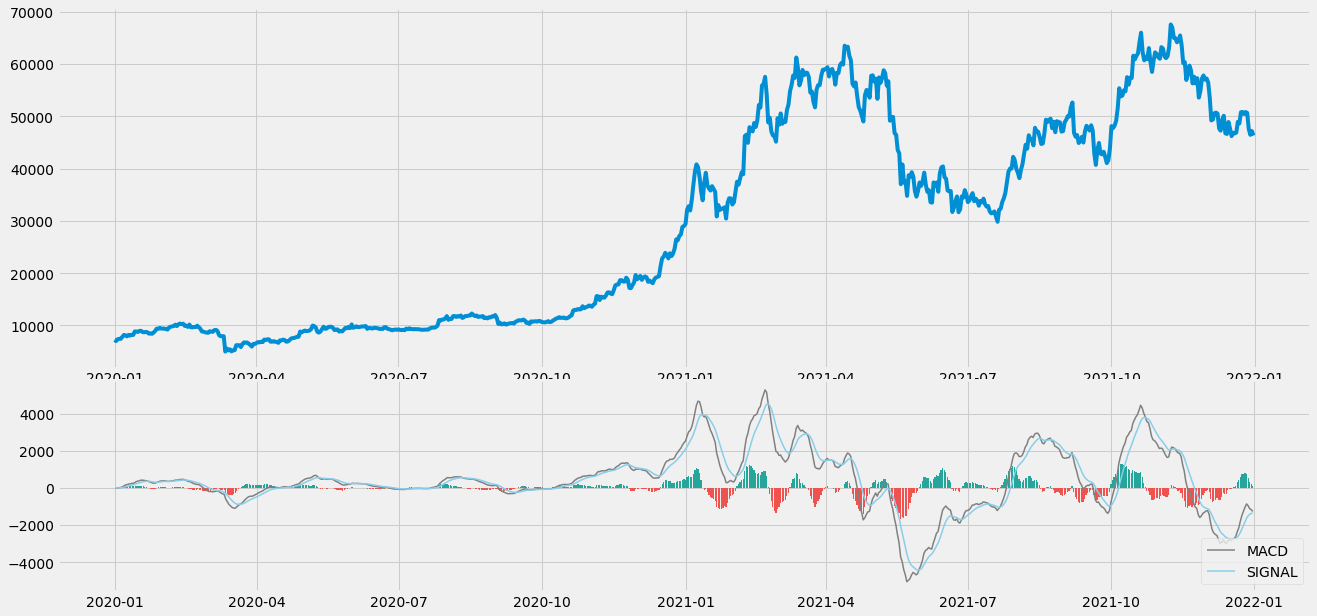

In [92]:
plot_macd(aapl['Close'], aapl_macd['macd'], aapl_macd['signal'], aapl_macd['hist'])

In [93]:
def implement_macd_strategy1(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

In [31]:
def implement_macd_strategy2(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i] and data['macd'][i] > data['hist'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i] and data['macd'][i] < data['hist'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

In [94]:
buy_price, sell_price, macd_signal = implement_macd_strategy1(aapl['Close'], aapl_macd)

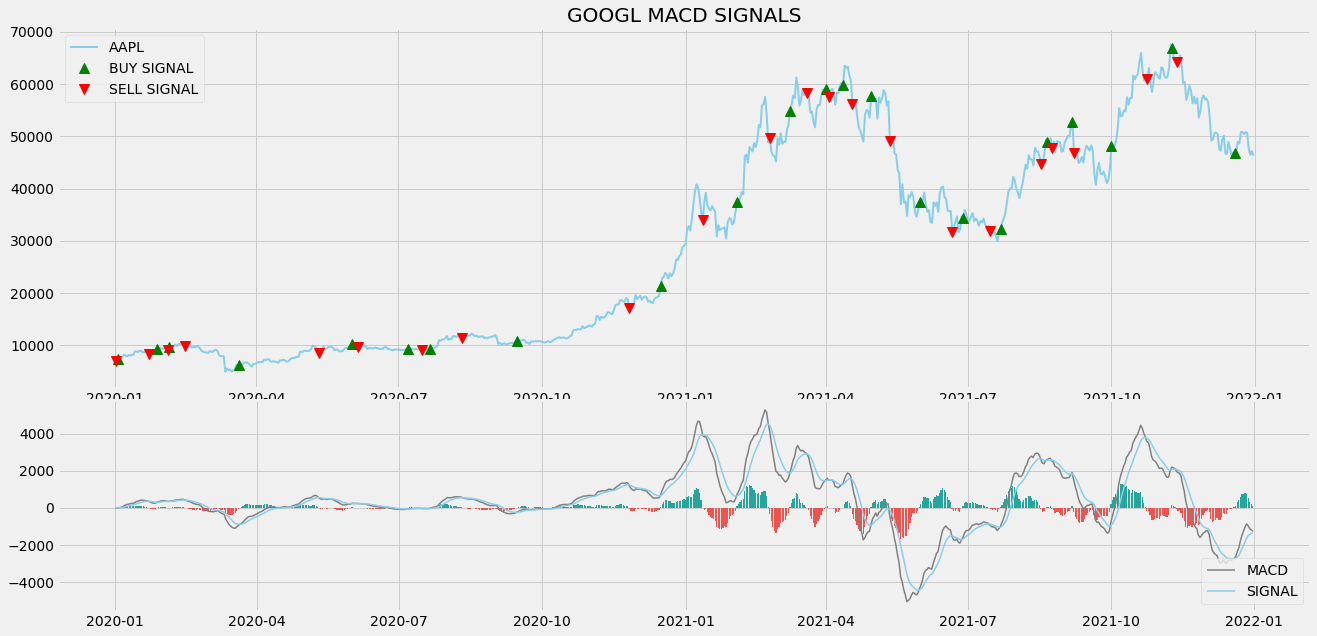

In [95]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(aapl['Close'], color = 'skyblue', linewidth = 2, label = 'AAPL')
ax1.plot(aapl.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(aapl.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
ax2.plot(aapl_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(aapl_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(aapl_macd)):
    if str(aapl_macd['hist'][i])[0] == '-':
        ax2.bar(aapl_macd.index[i], aapl_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(aapl_macd.index[i], aapl_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

In [96]:
position = []
for i in range(len(macd_signal)):
  if macd_signal[i] > 1:
      position.append(0)
  else:
    position.append(1)
        
for i in range(len(aapl['Close'])):
  if macd_signal[i] == 1:
      position[i] = 1
  elif macd_signal[i] == -1:
      position[i] = 0
  else:
      position[i] = position[i-1]
        
macd = aapl_macd['macd']
signal = aapl_macd['signal']
close_price = aapl['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(aapl.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(aapl.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,macd,signal,macd_signal,macd_position
Date,,,,,
2020-01-01,7200.174316,0.000000,0.000000,0,1
2020-01-02,6985.470215,-17.127393,-3.425479,-1,0
2020-01-03,7344.884277,-1.679899,-3.076363,1,1
2020-01-04,7410.656738,15.688789,0.676668,0,1
2020-01-05,7411.317383,29.170646,6.375463,0,1
...,...,...,...,...,...
2021-12-27,50640.417969,-864.435586,-1635.771146,0,1
2021-12-28,47588.855469,-963.158844,-1501.248686,0,1
2021-12-29,46444.710938,-1120.800746,-1425.159098,0,1


In [97]:
aapl_ret = pd.DataFrame(np.diff(aapl['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value/aapl['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing $100k in AAPL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))


Profit gained from the MACD strategy by investing $100k in AAPL : 420472.03
Profit percentage of the MACD strategy : 420%
